<a href="https://colab.research.google.com/github/evmpython/2_codigos_gerais/blob/main/C%C3%B3pia_de_CAT004_Aula_01_Radiossondagens_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Disciplina:** CAT010 - Meteorologia Física


---





## **Aula Prática 1:** $\underline{Trabalhando\ com\ dados\ de\ Radiossondagens}$

---


**OBJETIVO:** Nesta aula prática aprenderemos como baixar  e plotar dados de radiossondagens. Para isto será utilizado os dados da Universidade de [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).



---


**DADOS DE ENTRADA**: Arquivos texto de radiossondagem.

- **Tipo do dado:** tabela  
- **Formato do dado:** arquivo TEXTO
- **Nome do arquivo:** Não tem
- **Fonte dos dados:** http://weather.uwyo.edu/upperair/sounding.html



---

**DADOS DE SAÍDA:** Figura e arquivo CSV
- **Tipo do dado:** Figura e tabela
- **Formato do dado:** arquivo JPG e CSV
- **Imagens geradas:**
    1. skewt_SBGL_2022-10-30 12:00:00.jpg
    2. SBGL_2022-10-30 12:00:00.csv



---



**PROCEDIMENTO REALIZADO:** Os seguintes procedimentos são realizados nesse código:

1.   Download dos dados de uma sondagem atmosférica para uma determinada data/horário;
2.   Tratamento dos dados (eliminação de dados ausentes);
3.   Cálculo dos índices termodinâmicos;
4.   Plotagem do Skew-T Log-P com a Hodógrafa;
5.   Salvar os dados em arquivo csv.


---




**OBSERVAÇÕES IMPORTANTES**:
1. Mudar o caminho para o do seu drive.
2. Escolher a estação de radiossondagem. A escolha pode ser realizada inserindo o `código númerico` ou a `sigla` da estação.
3. Escolher a `data/horário` da radiossondagem.



---

- **Realizado por:** [Willy Hagi](https://taggo.one/willyhagi) da Meteonorte
- **Atualizado por:** Enrique V. Mattos - 22/10/2021, Atualizado em: 22/10/2023


---


**Exemplo do gráfico que será gerado nessa aula:**

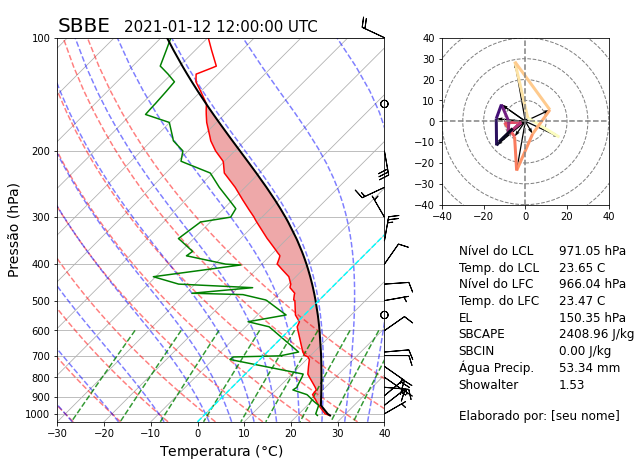

# **1° Passo:** Instalando o `Siphon`
O [`Siphon`](https://github.com/Unidata/siphon) é um pacote que reúne uma coleção de funcionalidades que permitem o acesso de alguns bancos de dados meteorológicos. Para a nossa aula prática, vamos acessar o banco de dados de radiossondagens mantido pela [*Wyoming University*](http://weather.uwyo.edu/upperair/sounding.html).

Outros bancos de dados:
* *Integrated Global Radiosonde Archive version 2* (IGRA v2);
* *Iowa State’s upper air archive*;
* *National Data Buoy Center* (NDBC).

Vamos instalar o `Siphon` no **Colab**:

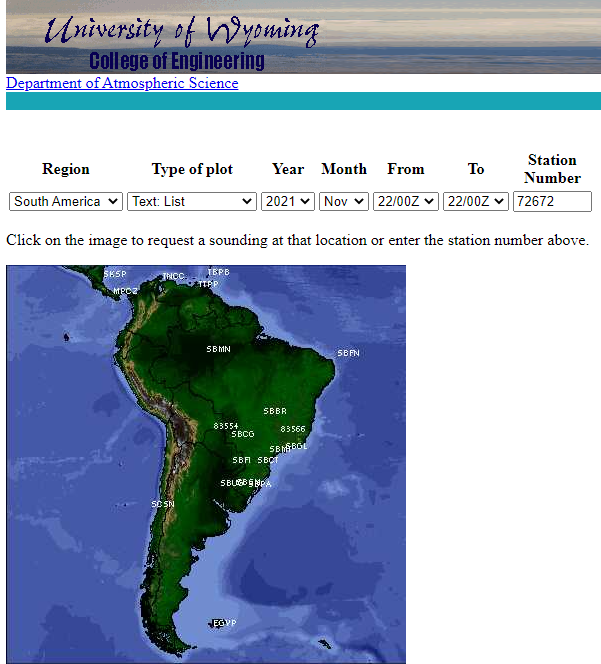

In [ ]:
!pip install siphon

# **2° Passo:** Instalando o `MetPy`
O [`MetPy`](https://unidata.github.io/MetPy/latest/index.html) foi um dos primeiros pacotes voltados exclusivamente para meteorologia no ecossistema científico do Python. É mantido até hoje pela UCAR/UNIDATA e por uma série de pesquisadores/programadores voluntários.

Vamos instalar o `MetPy` no **Colab**:

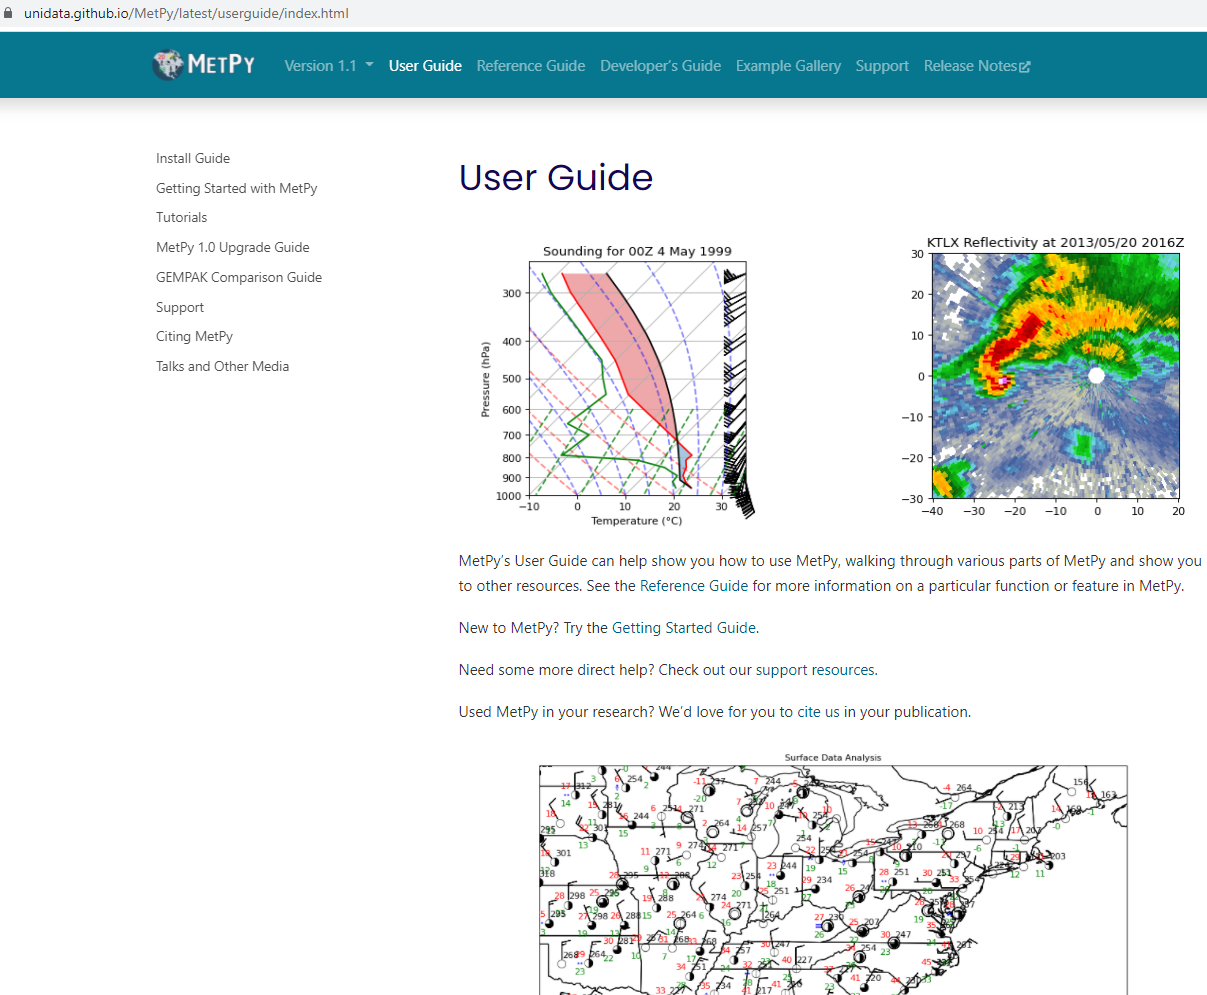

In [ ]:
!pip install metpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.5/400.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.0/294.0 kB 30.3 MB/s eta 0:00:00


# **3° Passo:** Importando Bibliotecas

In [ ]:
# Exemplo: import nome_biblioteca as apelido

import numpy as np                                           # biblioteca para trabalhar com matrizes
from datetime import datetime                                # biblioteca para trabalhar com datas

from siphon.simplewebservice.wyoming import WyomingUpperAir  # biblioteca siphon para baixar os dados de radiossodagens

from metpy.units import units                                # função unidades do metpy
import metpy.calc as mpcalc                                  # função que calcula variáveis termodinâmicas do metpy
from metpy.plots import Hodograph                            # função que plota hodrágrafa do metpy
from metpy.plots import SkewT                                # função que plota o gráfico Skew-T do metpy

import matplotlib.pyplot as plt                              # biblioteca para plotar gráficos
import matplotlib.gridspec as gridspec                       # função do matplotlib para plotar várias sub-figuras em uma figura
from mpl_toolkits.axes_grid1.inset_locator import inset_axes # função do matplotlib para inserir eixos em uma figura

# **4° Passo:** Montando drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **5° Passo:** Caminho do diretório - **### >>> MUDANÇAS AQUI <<< ###**
- Insira aqui o caminho da pasta do seu Google Drive onde esta o código dessa aula.

In [ ]:
# nome do diretório
dir = '/content/drive/MyDrive/00_DISPONIBILIZAÇÃO_DE_AULAS/2_SEGUNDO_SEMESTRE/CAT004 - METEOROLOGIA FÍSICA/AULAS/CAT010 - PYTHON PARA METEOROLOGIA FÍSICA/AULA_01_RADIOSSONDAGENS/'

In [ ]:
# cria a pasta de saídade com o nome "output"
import os
os.makedirs(f'{dir}output/', exist_ok=True)

# **6° Passo:** Declarando a função

* Função que baixa e plota os dados de uma radissondagem

In [ ]:
def plotar_painel(p, t, td, niveis, nome_estacao, hora, seu_nome, dir):

  pressao = p
  temperatura = t
  orvalho = td

  lcl_pressao, lcl_temperatura = mpcalc.lcl(pressao[0], temperatura[0], orvalho[0])  # calculando LCL
  lfc_pressao, lfc_temperatura = mpcalc.lfc(pressao, temperatura, orvalho)           # calculando LFC
  el_pressao, el_temperatura = mpcalc.el(pressao, temperatura, orvalho)              # calculando EL
  sbcape, sbcin = mpcalc.surface_based_cape_cin(pressao, temperatura, orvalho)       # calculando CAPE e CINE
  agua_precipitavel = mpcalc.precipitable_water(pressao, orvalho)                    # calculando ÁGUA PRECIPITÁVEL
  showalter = mpcalc.showalter_index(pressao, temperatura, orvalho)                  # calculando ÍNDICE SHOWALTER

  # criando a moldura da figura
  fig = plt.figure(figsize=(9, 9))

  # gridspec
  gs = gridspec.GridSpec(3, 3)
  skew = SkewT(fig, rotation=45, subplot=gs[0:2, :2])

  # temperaturas e barbelas de vento
  skew.plot(pressao, temperatura, color='red',)
  skew.plot(pressao, orvalho, color='green')
  skew.plot_barbs(pressao[niveis], vento_u[niveis], vento_v[niveis])

  # adicionar linhas relevantes no skew-t
  skew.plot_dry_adiabats()
  skew.plot_moist_adiabats()
  skew.plot_mixing_lines()

  # calcular o perfil da parcela de ar
  perfil = mpcalc.parcel_profile(pressao, temperatura[0], orvalho[0]).to('degC')
  skew.plot(pressao, perfil, color='black', linewidth=2)

  # cape e cin
  skew.shade_cin(pressao, temperatura, perfil, orvalho)
  skew.shade_cape(pressao, temperatura, perfil)

  # realçar isoterma de 0 degC
  skew.ax.axvline(0, color='cyan', linestyle='--')

  # ajuste do skew-t
  skew.ax.set_xlim(-30, 40)

  # legendas dos eixos
  plt.xlabel(r'Temperatura ($\degree$C)', fontsize=14)
  plt.ylabel(r'Pressão (hPa)', fontsize=14)
  plt.title(f'{nome_estacao}', fontsize=20, loc='left')
  plt.title(f'{hora} UTC', fontsize=15, loc='center')

  # incluir hodógrafo
  ax = fig.add_subplot(gs[0:1, -1])
  hodografo = Hodograph(ax, component_range=80.)
  hodografo.add_grid(increment=10)
  hodografo.plot_colormapped(vento_u[niveis], vento_v[niveis], pressao[niveis],
                           cmap='BuPu_r')
  hodografo.wind_vectors(vento_u[niveis], vento_v[niveis])

  # retirar ticks dos eixos
  #ax.set_xticks([])
  #ax.set_yticks([])

  # colocar limites em x e y
  ax.set_xlim(-40, 40)
  ax.set_ylim(-40, 40)

  # parâmetros termodinâmicos
  ax3 = fig.add_subplot(gs[1, -1])
  ax3.axis('off')

  # coluna 1
  ax3.text(0.1, 1,'Nível do LCL', size = 12)
  ax3.text(0.1, 0.9,'Temp. do LCL', size = 12)
  ax3.text(0.1, 0.8,'Nível do LFC', size = 12)
  ax3.text(0.1, 0.7,'Temp. do LFC', size = 12)
  ax3.text(0.1, 0.6,'EL', size = 12)
  ax3.text(0.1, 0.5,'SBCAPE', size = 12)
  ax3.text(0.1, 0.4,'SBCIN', size = 12)
  ax3.text(0.1, 0.3,'Água Precip.', size = 12)
  ax3.text(0.1, 0.2,'Showalter', size = 12)

  # coluna 2
  ax3.text(0.7, 1, '{:.2f} hPa'.format(np.array(lcl_pressao)), size = 12)
  ax3.text(0.7, 0.9, '{:.2f} C'.format(np.array(lcl_temperatura)), size = 12)
  ax3.text(0.7, 0.8, '{:.2f} hPa'.format(np.array(lfc_pressao)), size = 12)
  ax3.text(0.7, 0.7, '{:.2f} C'.format(np.array(lfc_temperatura)), size = 12)
  ax3.text(0.7, 0.6, '{:.2f} hPa'.format(np.array(el_pressao)), size = 12)
  ax3.text(0.7, 0.5, '{:.2f} J/kg'.format(np.array(sbcape)), size = 12)
  ax3.text(0.7, 0.4, '{:.2f} J/kg'.format(np.array(sbcin)), size = 12)
  ax3.text(0.7, 0.3, '{:.2f} mm'.format(np.array(agua_precipitavel)), size = 12)
  ax3.text(0.7, 0.2, '{:.2f}'.format(np.array(showalter)[0]), size = 12)
  ax3.text(0.1, 0.01, 'Elaborado por: ' + seu_nome, size = 12)

  plt.tight_layout()

  plt.savefig(f'{dir}output/skewt_{nome_estacao}_{hora}.jpg', dpi=300, bbox_inches='tight')

  plt.show()

# **PARTE 1):**  Insira a **data** e **sigla** da estação
**### FAZER AS MUDANÇAS AQUI ###**:


**SIGLA DA ESTAÇÃO**

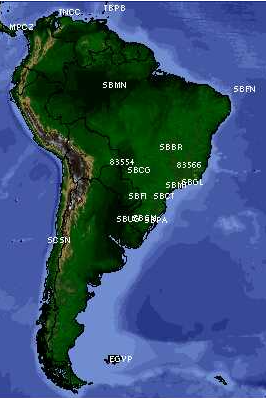

In [ ]:
nome_estacao = 'SBGL'

# Exemplos de estações com sigla e código
# Galeão.........: SBGL ou 83746
# SP-Marte.......: SBMT ou 83779
# BR.............: SBBR ou 83378
# Curitiba.......: SBCT ou 83840
# Florianópolis..: SBFL ou 83899
# Uberlândia......:SBUL ou 83525

**DATA**

In [ ]:
ano = 2022
mes = 10
dia = 30
hor = 12

# **PARTE 2):** Baixando os dados

**Baixando os dados da radiossondagem em formato de tabela (DataFrame)**

In [ ]:
# exibe a data escolhida
print(ano, mes, dia, hor)

2022 10 30 12


In [ ]:
# exibe a sigla da estação
print(nome_estacao)

SBGL


In [ ]:
df_estacao = WyomingUpperAir.request_data(datetime(ano, mes, dia, hor), nome_estacao)

**Exibindo a tabela de dados**

In [ ]:
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1008.0,9.0,27.4,21.4,100,6,-5.908847,1.041889,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
1,1002.0,62.0,25.6,21.1,70,8,-7.517541,-2.736161,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
2,1000.0,80.0,25.4,21.0,60,8,-6.928203,-4.000000,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
3,978.0,276.0,23.8,20.3,29,10,-4.848096,-8.746197,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
4,947.0,559.0,25.4,13.4,345,12,3.105829,-11.591110,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,30.0,23890.0,-59.5,-85.5,95,21,-20.920089,1.830271,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
97,29.0,24103.0,-59.2,-85.5,100,14,-13.787309,2.431074,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
98,28.0,24322.0,-58.8,-85.5,75,8,-7.727407,-2.070552,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
99,27.1,24527.0,-58.5,-85.5,57,18,-15.096070,-9.803503,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74


**Exibindo uma coluna da tabela de dados**

In [ ]:
df_estacao['temperature']

0      27.4
1      25.6
2      25.4
3      23.8
4      25.4
       ... 
96    -59.5
97    -59.2
98    -58.8
99    -58.5
100     NaN
Name: temperature, Length: 101, dtype: float64

**Plotando gráfico:** temperatura do ar

<Axes: >

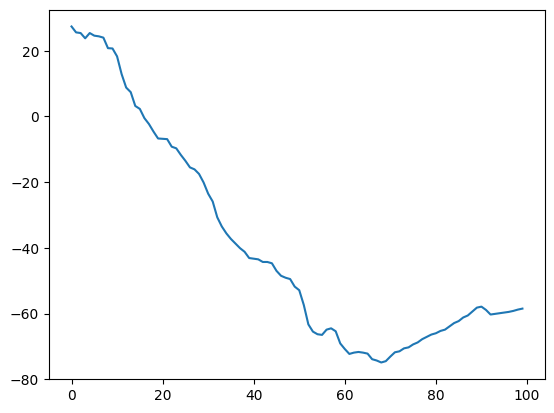

In [ ]:
# plotando de maneira simples
df_estacao['temperature'].plot()

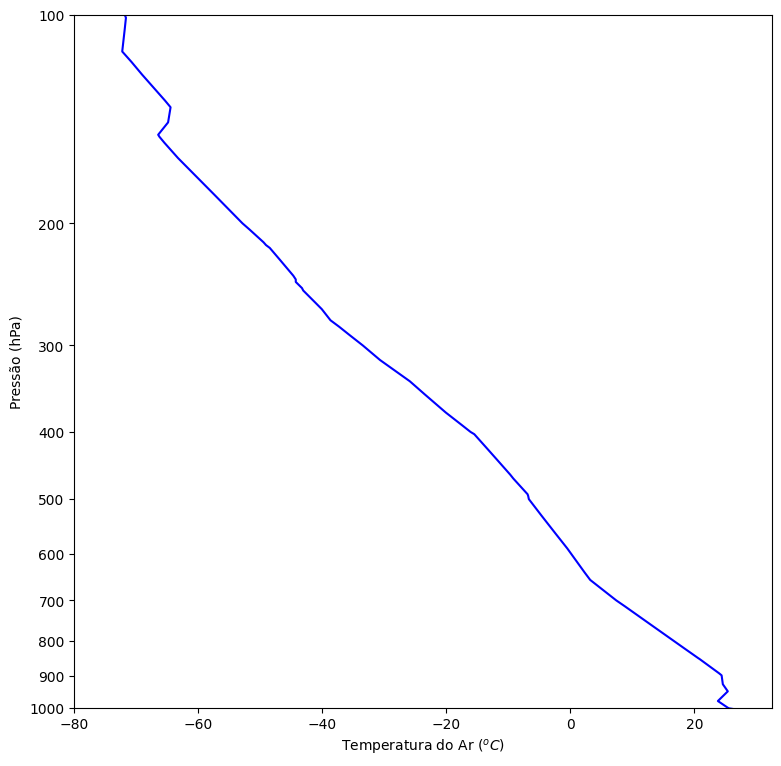

In [ ]:
# plotando de mais completa
from matplotlib.ticker import (MultipleLocator, NullFormatter, ScalarFormatter)

fig, ax = plt.subplots(figsize=(9, 9))

# perfil de temperatura
ax.semilogy(df_estacao['temperature'], df_estacao['pressure'], color='blue')

# formatação dos eixos
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_minor_formatter(NullFormatter())

# ticks no eixo y
ax.set_yticks(np.linspace(100, 1000, 10))

# limite em y (imitando o limite do Skew-T)
ax.set_ylim(100, 1000)

# inverter eixo y
plt.gca().invert_yaxis()

ax.set_ylabel('Pressão (hPa)')
ax.set_xlabel('Temperatura do Ar ($^{o}C$)')

plt.show()

# **PARTE 4):** Tratamento dos dados

**Eliminando dados NaN (*Not A Number* = Não é número)**

In [ ]:
# retirar nan da tabela
df_estacao = df_estacao.dropna()

In [ ]:
# mostrando a tabela
df_estacao

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1008.0,9.0,27.4,21.4,100,6,-5.908847,1.041889,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
1,1002.0,62.0,25.6,21.1,70,8,-7.517541,-2.736161,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
2,1000.0,80.0,25.4,21.0,60,8,-6.928203,-4.000000,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
3,978.0,276.0,23.8,20.3,29,10,-4.848096,-8.746197,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
4,947.0,559.0,25.4,13.4,345,12,3.105829,-11.591110,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,31.0,23685.0,-59.7,-85.7,115,12,-10.875693,5.071419,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
96,30.0,23890.0,-59.5,-85.5,95,21,-20.920089,1.830271,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
97,29.0,24103.0,-59.2,-85.5,100,14,-13.787309,2.431074,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
98,28.0,24322.0,-58.8,-85.5,75,8,-7.727407,-2.070552,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74


In [ ]:
# descrevendo as estatísticas básicas
df_estacao.describe()

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station_number,latitude,longitude,elevation,pw
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.00000,100.000000,100.000000,100.0,1.000000e+02,100.00,100.0,1.000000e+02
mean,292.909000,12795.940000,-39.402000,-52.642000,207.000000,27.63000,17.948388,3.663436,83746.0,-2.281000e+01,-43.25,9.0,4.674000e+01
std,287.388834,7281.110753,32.428551,38.152173,92.360405,17.09135,23.489070,13.135870,0.0,3.570612e-15,0.00,0.0,1.428245e-14
min,27.100000,9.000000,-74.900000,-90.900000,0.000000,2.00000,-20.920089,-19.151111,83746.0,-2.281000e+01,-43.25,9.0,4.674000e+01
25%,65.250000,7071.000000,-65.425000,-86.150000,102.250000,15.00000,-6.163686,-4.615530,83746.0,-2.281000e+01,-43.25,9.0,4.674000e+01
50%,202.000000,12315.500000,-52.350000,-66.900000,245.000000,21.00000,18.718668,1.255532,83746.0,-2.281000e+01,-43.25,9.0,4.674000e+01
75%,426.500000,19121.250000,-13.050000,-17.175000,270.000000,42.25000,39.742539,11.688334,83746.0,-2.281000e+01,-43.25,9.0,4.674000e+01
max,1008.000000,24527.000000,27.400000,21.400000,345.000000,64.00000,58.003698,33.841010,83746.0,-2.281000e+01,-43.25,9.0,4.674000e+01


In [ ]:
# selecionando as linhas com temperaturas < 29,2oC
df_estacao_novo = df_estacao[ df_estacao['temperature'] < 29.2]

In [ ]:
# mostrando a tabela
df_estacao_novo

,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1008.0,9.0,27.4,21.4,100,6,-5.908847,1.041889,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
1,1002.0,62.0,25.6,21.1,70,8,-7.517541,-2.736161,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
2,1000.0,80.0,25.4,21.0,60,8,-6.928203,-4.000000,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
3,978.0,276.0,23.8,20.3,29,10,-4.848096,-8.746197,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
4,947.0,559.0,25.4,13.4,345,12,3.105829,-11.591110,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,31.0,23685.0,-59.7,-85.7,115,12,-10.875693,5.071419,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
96,30.0,23890.0,-59.5,-85.5,95,21,-20.920089,1.830271,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
97,29.0,24103.0,-59.2,-85.5,100,14,-13.787309,2.431074,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
98,28.0,24322.0,-58.8,-85.5,75,8,-7.727407,-2.070552,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74


In [ ]:
# mostrando o tipo do objeto "tabela"
type(df_estacao_novo)

pandas.core.frame.DataFrame

**Atribuindo as variáveis que serão utilizadas e inserindo unidades nos dados**
- **Values**: tranforma de DataFrame para vetor (array unidimensional)

In [ ]:
df_estacao['pressure']

0     1008.0
1     1002.0
2     1000.0
3      978.0
4      947.0
       ...  
95      31.0
96      30.0
97      29.0
98      28.0
99      27.1
Name: pressure, Length: 100, dtype: float64

In [ ]:
df_estacao['pressure'].values

array([1008. , 1002. , 1000. ,  978. ,  947. ,  925. ,  898. ,  892. ,
        850. ,  849. ,  820. ,  758. ,  714. ,  700. ,  654. ,  638. ,
        589. ,  562. ,  529. ,  500. ,  495. ,  492. ,  467. ,  461. ,
        440. ,  422. ,  403. ,  400. ,  391. ,  375. ,  353. ,  338. ,
        315. ,  300. ,  290. ,  282. ,  276. ,  266. ,  260. ,  250. ,
        248. ,  247. ,  243. ,  241. ,  238. ,  225. ,  217. ,  215. ,
        213. ,  204. ,  200. ,  182. ,  161. ,  153. ,  150. ,  149. ,
        143. ,  136. ,  133. ,  122. ,  117. ,  113. ,  105. ,  101. ,
        100. ,   98. ,   87. ,   85. ,   81.3,   80. ,   75. ,   71. ,
         70. ,   67. ,   66. ,   63. ,   61. ,   58. ,   56. ,   54. ,
         53. ,   51. ,   50. ,   48. ,   46. ,   45. ,   43. ,   42. ,
         40. ,   38. ,   37.6,   36. ,   33.9,   33. ,   32. ,   31. ,
         30. ,   29. ,   28. ,   27.1])

In [ ]:
# registrando unidades
pressao = df_estacao['pressure'].values * units('hPa')
temperatura = df_estacao['temperature'].values * units('celsius')
orvalho = df_estacao['dewpoint'].values * units('celsius')
vento_u = df_estacao['u_wind'].values * units('m/s')
vento_v = df_estacao['v_wind'].values * units('m/s')

In [ ]:
# mostrando os valores de PRESSÃO
pressao

Magnitude,[1008.0 1002.0 1000.0 978.0 947.0 925.0 898.0 892.0 850.0 849.0 820.0 758.0 714.0 700.0 654.0 638.0 589.0 562.0 529.0 500.0 495.0 492.0 467.0 461.0 440.0 422.0 403.0 400.0 391.0 375.0 353.0 338.0 315.0 300.0 290.0 282.0 276.0 266.0 260.0 250.0 248.0 247.0 243.0 241.0 238.0 225.0 217.0 215.0 213.0 204.0 200.0 182.0 161.0 153.0 150.0 149.0 143.0 136.0 133.0 122.0 117.0 113.0 105.0 101.0 100.0 98.0 87.0 85.0 81.3 80.0 75.0 71.0 70.0 67.0 66.0 63.0 61.0 58.0 56.0 54.0 53.0 51.0 50.0 48.0 46.0 45.0 43.0 42.0 40.0 38.0 37.6 36.0 33.9 33.0 32.0 31.0 30.0 29.0 28.0 27.1]
Units,hectopascal


In [ ]:
# mostrando os valores de TEMPERATURA
temperatura

Magnitude,[27.4 25.6 25.4 23.8 25.4 24.6 24.4 24.0 20.8 20.7 18.3 12.9 8.8 7.4 3.2 2.3 -0.5 -2.3 -4.6 -6.7 -6.8 -6.9 -9.2 -9.7 -11.7 -13.5 -15.5 -16.1 -17.5 -20.1 -23.5 -25.9 -30.7 -33.5 -35.6 -37.3 -38.7 -40.1 -41.2 -43.1 -43.3 -43.5 -44.3 -44.3 -44.7 -47.0 -48.5 -49.1 -49.5 -51.8 -52.9 -57.4 -63.3 -65.5 -66.3 -66.5 -64.9 -64.5 -65.4 -69.1 -70.8 -72.3 -71.9 -71.7 -71.9 -72.2 -73.9 -74.3 -74.9 -74.5 -73.1 -71.8 -71.5 -70.6 -70.3 -69.4 -68.8 -67.8 -67.1 -66.4 -66.0 -65.3 -64.9 -63.9 -62.9 -62.3 -61.2 -60.6 -59.4 -58.2 -57.9 -58.9 -60.3 -60.1 -59.9 -59.7 -59.5 -59.2 -58.8 -58.5]
Units,degree_Celsius


In [ ]:
# mostrando os valores de TEMPERATURA DO PONTO DE ORVALHO
orvalho

Magnitude,[21.4 21.1 21.0 20.3 13.4 12.6 10.4 10.0 8.8 8.8 8.0 6.3 4.9 4.5 2.0 1.2 -1.2 -3.2 -5.7 -8.1 -9.2 -9.9 -12.5 -13.2 -15.6 -17.7 -20.0 -20.5 -21.4 -23.0 -28.8 -32.9 -33.4 -37.1 -39.5 -41.5 -44.7 -66.1 -62.8 -57.1 -59.3 -48.0 -51.3 -63.3 -72.7 -67.7 -64.5 -63.1 -52.7 -55.2 -56.4 -62.0 -69.3 -69.4 -69.5 -69.8 -90.9 -81.5 -82.0 -83.7 -84.6 -85.3 -85.6 -85.7 -85.9 -86.0 -86.6 -86.7 -86.9 -87.1 -87.8 -88.3 -88.5 -88.5 -88.6 -88.6 -88.7 -88.7 -88.8 -88.8 -88.8 -88.9 -88.9 -88.5 -88.0 -87.8 -87.3 -87.1 -86.5 -86.0 -85.9 -86.1 -86.3 -86.1 -85.9 -85.7 -85.5 -85.5 -85.5 -85.5]
Units,degree_Celsius


In [ ]:
# mostrando os valores de VENTO ZONAL
vento_u

Magnitude,[-5.908846518073248 -7.5175409662872665 -6.928203230275509 -4.8480962024633705 3.105828541230248 5.814342436536366 9.079809994790939 9.696192404926737 16.06969024216349 18.38477631085024 19.151111077974452 19.91715552109343 20.68096281325637 20.68096281325637 24.965738368864347 26.0 28.837850878149563 29.001849185172798 19.05255888325765 15.407232379623048 20.68096281325637 19.696155060244163 13.787308542170914 15.035081932574533 16.0 14.772116295183121 22.9684792993552 23.908672754201895 26.589809331329615 32.27887082421558 40.56888470414087 43.03849443228744 45.55233116211223 47.81734550840379 48.0 45.748007186940576 44.173223255144876 39.46709007300815 37.158619268502655 45.03332099679079 46.35484447838799 46.79622242152313 48.53487850015501 48.940620499979104 50.62776693988422 56.98962375105503 57.676633111558324 57.321249867940416 57.8819864428265 58.0036983703456 53.69357503463518 48.329970613050506 46.28703423791406 45.03332099679079 45.89934640057523 47.229464185527384 56.191082796272305 36.466068134726314 28.670321550114704 16.741731801207536 20.920088659926655 25.605001578317413 29.943700614961116 29.0 29.0 24.90486745229364 14.14213562373095 10.606601717798211 15.65036161174089 17.0 18.126155740733 1.568803369457843 1.568803369457843 -11.276311449430901 -12.0 -7.18451044959189 -0.0 -0.6840402866513378 -10.0 -16.3135401666597 -10.724622203665692 -4.242640687119285 -11.0 -14.500924592586399 -10.832885283134289 -9.84807753012208 -13.92558475291286 -14.942920471376183 -13.106432708623869 -10.724622203665692 -12.287280664334878 -18.352590699492296 -13.641180906993293 -10.8756934444398 -4.91491226573395 -10.8756934444398 -20.920088659926655 -13.787308542170912 -7.7274066103125465 -15.096070223017634]
Units,meter/second


In [ ]:
# mostrando os valores de VENTO MERIDIONAL
vento_v

Magnitude,[1.0418890660015818 -2.7361611466053506 -4.000000000000001 -8.746197071393958 -11.59110991546882 -15.974774553360444 -17.820130483767358 -17.492394142787916 -19.151111077974445 -18.38477631085023 -16.06969024216348 -16.71247785185002 -3.6466117310055295 -3.6466117310055295 -1.3083989060735985 4.776122516674677e-15 -8.269120674509981 -13.523784375702387 -11.000000000000002 -7.184510449591893 -3.6466117310055295 -3.4729635533385994 -2.4310744873370194 -5.472322293210704 2.9391523179536475e-15 -2.6047226650039494 1.203726993587719 2.091737825943798 4.688500797007119 6.861085796986073 10.870399894305866 9.14811439598143 6.401962644163028 4.183475651887596 8.817456953860943e-15 4.808309310312055 8.586404791944508 14.36484601967808 17.327348731368666 26.00000000000002 25.694909873055853 24.88199282765221 23.6720419266102 22.821386133997756 21.49021206691006 15.270323661048717 19.859657421886556 20.863228742865783 22.218812871808645 27.047568751404746 31.00000000000003 33.841009744711734 27.812056045142942 26.00000000000002 26.500000000000025 26.17971949330219 26.20233222792335 22.786528362027816 20.075175272286625 2.952019020337816 -1.8302705977008156 -4.5148526193401795 8.02339039817814 5.327213576290986e-15 5.327213576290986e-15 -2.1788935686914472 14.142135623730955 10.606601717798215 3.3265870530841566 3.1228493378257506e-15 8.452365234813984 17.93150456565142 17.93150456565142 4.104241719908025 -7.347880794884119e-16 -15.407232379623048 -11.0 1.8793852415718166 -6.123233995736766e-16 -7.60712871133259 -8.99902653561155 -4.242640687119286 -6.735557395310443e-16 -6.761892187851191 1.9101299543362333 1.736481776669303 -9.750799417967785 1.3073361412148736 -9.177222981616739 -8.99902653561155 -8.603646545265692 -4.917561856947894 3.1493147608141103 5.071419140888392 3.441458618106277 5.071419140888392 1.830270597700823 2.4310744873370242 -2.070552360820166 -9.803502630270488]
Units,meter/second


**Criando um intervalo de níveis de pressão através de `np.arange()` entre os níveis de `1000 hPa a 100 hPa`**

In [ ]:
np.arange(1, 150, 1)

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149])

In [ ]:
niveis = np.arange(100, 1050, 50) * units('hPa') # mbar para milibar
niveis

Magnitude,[ 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850 900 950 1000]
Units,hectopascal


In [ ]:
# quantidade de pontos da variável "niveis"
len(niveis)

19

In [ ]:
# mostrando a pressão
pressao

Magnitude,[1008.0 1002.0 1000.0 978.0 947.0 925.0 898.0 892.0 850.0 849.0 820.0 758.0 714.0 700.0 654.0 638.0 589.0 562.0 529.0 500.0 495.0 492.0 467.0 461.0 440.0 422.0 403.0 400.0 391.0 375.0 353.0 338.0 315.0 300.0 290.0 282.0 276.0 266.0 260.0 250.0 248.0 247.0 243.0 241.0 238.0 225.0 217.0 215.0 213.0 204.0 200.0 182.0 161.0 153.0 150.0 149.0 143.0 136.0 133.0 122.0 117.0 113.0 105.0 101.0 100.0 98.0 87.0 85.0 81.3 80.0 75.0 71.0 70.0 67.0 66.0 63.0 61.0 58.0 56.0 54.0 53.0 51.0 50.0 48.0 46.0 45.0 43.0 42.0 40.0 38.0 37.6 36.0 33.9 33.0 32.0 31.0 30.0 29.0 28.0 27.1]
Units,hectopascal


**E esse intervalo de `niveis` vai servir para "filtrar" os dados de vento para o diagrama, com o uso de `mpcalc.resample_nn_1d()`.**

In [ ]:
len(pressao)

100

In [ ]:
len(niveis)

19

In [ ]:
niveis = mpcalc.resample_nn_1d(pressao, niveis)
niveis

[64, 54, 50, 39, 33, 30, 27, 24, 19, 17, 16, 14, 13, 11, 10, 8, 6, 4, 2]

**Extraindo o nome e data da estação**

In [ ]:
# para o título
nome = df_estacao['station'][0]
dia = df_estacao['time'][0]

In [ ]:
nome

'SBGL'

In [ ]:
dia

Timestamp('2022-10-30 12:00:00')

# **PARTE 5):** Plotando o gráfico

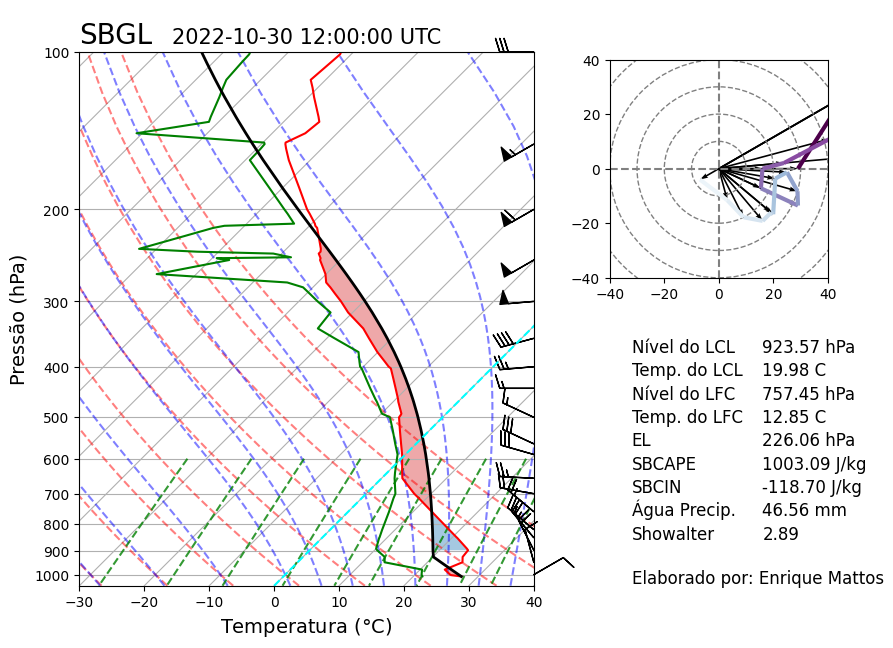

In [ ]:
# plotar painel termodinâmico com a função
plotar_painel(pressao, temperatura, orvalho, niveis, nome_estacao, dia, 'Enrique Mattos', dir)

# Segue o link de um manual explicando os termos técnicos do Gráfico Skew-T Log-P: [Manual Skew-T](https://www.dropbox.com/s/sdm5etisv065lt7/Manual%20Informativo%20-%20SKEW-T.pdf?dl=0)

# **PARTE 6):** Gerando outros parâmetros meteorológicos e salvando num arquivo `CSV`

- Outro aspecto importante da análise de radiossondagens é o cálculo de algumas variáveis de interesse, como a própria Umidade Relativa (que é colocada na tabela no portal da Wyoming, mas que não é disponibilizada pelo Siphon), Temperatura Potencial e outras.

- O `mpcalc` também possui várias funções para o cálculo dessas variáveis e, novamente, a lista é extensa.

- Por exemplo, podemos calcular:
   - Umidade Relativa a partir da Temperatura do Ponto de Orvalho: `.relative_humidity_from_dewpoint()`, que precisa da temperatura do ar e temperatura do ponto de orvalho como argumentos (e precisa multiplicar por 100 ao final).
   

**- Umidade relativa**

In [ ]:
umidade_relativa = mpcalc.relative_humidity_from_dewpoint(temperatura, orvalho) * 100
umidade_relativa

Magnitude,[69.7853657574779 76.19136186893229 76.63029222907024 80.7699765445222 47.358916312532564 47.14288629887352 41.247458551441696 41.13526618927254 46.10320677643641 46.38816117926838 51.01361875316678 64.18679074352181 76.50981826350204 81.82962542150617 91.82823736424852 92.43276258937279 95.01329803430232 93.53721169839663 92.00653414988132 89.75714107959503 83.01087905608475 79.1722556183443 76.92491220610026 75.60238277426342 72.78609513437645 70.61250219624102 68.38900952757847 68.84380239251625 71.58352801217549 77.6232006174627 61.70604943107616 51.82858459491555 77.11769960837435 69.95188471260806 67.32396550613919 64.8006100702696 53.04260582198403 4.503550362720456 7.86813310348278 19.937356341273357 15.461498470699297 60.94555128839252 45.536006169031324 10.254743774845492 2.878080878543204 7.590699111037886 13.913970882270318 17.94902286461701 68.93764123486656 66.67982803773873 65.55464038523705 55.65695141585172 43.93752815205124 58.18872003029539 63.983016660101555 63.01333196641714 1.6496299033631245 8.026560090951515 8.347784376318788 10.497236567488036 11.489844997940244 12.678900345324376 11.355273971171894 10.83980207407636 10.781288043115207 11.071673771174057 12.828770467121217 13.38555509338814 14.148758785136925 12.859594070061945 9.218698666442354 6.96590620834948 6.433689014644169 5.648189329566523 5.313819038226536 4.673420185301786 4.2167700316369245 3.665241944511118 3.2666025336293085 2.9663781273352368 2.808336796526735 2.507741083627205 2.375733324464255 2.23220726011617 2.137414360858529 2.046746087253987 1.937560567747092 1.8574945329238706 1.7700830700978472 1.6597647971595204 1.6265769199864628 1.7813460531153003 2.055889111950664 2.074820964329864 2.093859162589683 2.1130037648195206 2.132254826173114 2.0526180889693726 1.9514184844932054 1.8790763384631974]
Units,dimensionless


**- Razão de mistura**
- Razão de mistura a partir da Umidade Relativa: `.mixing_ratio_from_relative_humidity()`, cujos argumentos são pressão, temperatura e umidade relativa.

In [ ]:
razao_mistura = mpcalc.mixing_ratio_from_relative_humidity(pressao,
                                                           temperatura,
                                                           umidade_relativa)
razao_mistura

Magnitude,[1.630976827383338 1.6050502248606828 1.5978705469546703 1.561080711186549 1.0447407327142446 1.0142069052096192 0.9037267418207379 0.8852649285229639 0.8529360281065996 0.8538143833233941 0.8346602490057481 0.7987619757724177 0.766593142421402 0.7594939633076453 0.6792310655719562 0.6571922174636887 0.5972969070028348 0.5395410458091201 0.47438412668843816 0.4170111709962552 0.3865915922456931 0.3681193734172492 0.31493235806976766 0.30141965197135584 0.2592258623938165 0.22663066008198846 0.1949461090106156 0.18807505858793566 0.17786362384920512 0.16102660627404572 0.10090578749552906 0.07131065888030622 0.07283568548211208 0.05296233011276045 0.042864339402513975 0.03576795164443559 0.02593508073621826 0.00197701199991143 0.00314958835753781 0.006783692745806371 0.005190631888292361 0.02010608848375259 0.014005325874945558 0.0031801976185426577 0.0008653490811060906 0.0018737331048379001 0.003009044067390797 0.00365977900269016 0.01355517872764147 0.01049061543454621 0.009241508440354372 0.004994811069478614 0.002090728439948892 0.0021690200507931755 0.0021811881246024357 0.002104019899680118 7.135722327881705e-05 0.0003852666065185382 0.00036285611643977855 0.00029793852837202146 0.00026672638247946277 0.00024498339130669706 0.0002503722315782011 0.0002558324896392871 0.0002496026899146362 0.00025031953717597236 0.00025399767075082576 0.00025546661848245154 0.00025789447211936297 0.0002530374318832921 0.00023850813745660669 0.0002304872529508935 0.00022556569743943113 0.00023566817913147712 0.00023499073658018579 0.0002461841180198707 0.00024973674524526087 0.000262659415026735 0.00026720037939886263 0.00027710186452547056 0.00028233343307075434 0.00028818077441284393 0.0002939485543239581 0.00032900938385856717 0.0003753836254103752 0.0003976211865804624 0.000454630394063252 0.0004821619613839745 0.0005624484425407012 0.0006459413769501923 0.000664248085406309 0.0006700812967908349 0.0006872219789888977 0.0007309697512987802 0.0007804468045832729 0.0008340160762004886 0.0008921149956691639 0.0009229239085350709 0.0009559472775978212 0.0009877513874265702]
Units,dimensionless


**- Temperatura virtual** `.virtual_temperature()`, cujos argumentos são temperatura e razão de mistura.

In [ ]:
temperatura_virtual = mpcalc.virtual_temperature(temperatura,
                                                 razao_mistura)
temperatura_virtual

Magnitude,[140.6474696080752 137.4823157531548 137.01489830230963 133.8186797199595 118.1189193839536 115.72871780039497 110.25656016688191 108.81206006371912 103.04518942263155 102.96288212935673 98.89333839868743 90.10877166660089 83.16721119694006 81.0084758336613 71.14344391084916 68.69621313983839 61.471373840322656 55.39564915608338 47.92011468808204 40.96187755656604 38.33750506512149 36.644700187673266 29.225236181545483 27.387999927568842 21.014805776171556 15.659104462275877 10.0492058655106 8.633520792280649 5.964912059553512 1.2325521702842366 -9.591557525301198 -15.896399709637649 -20.695066730142713 -26.17322778674739 -29.66522361835436 -32.34950657376277 -35.097541653139984 -39.820500096807024 -40.75734692964852 -42.15782138813793 -42.5785648255214 -40.748752211077516 -42.37874546308444 -43.85903199383114 -44.57994289898298 -46.74291760426857 -48.09035172647353 -48.603414200849954 -47.681941888554604 -50.40321611552042 -51.674129244774576 -56.74824096929055 -63.03387813186191 -65.22682840665396 -66.02635758768216 -66.23627369179735 -64.89096822790722 -64.45115799579622 -65.35419647210298 -69.06305846812873 -70.76720298124886 -72.27009917966805 -71.86938076509887 -71.66868208194353 -71.86947485259785 -72.16943284171614 -73.86924620074132 -74.26913048344159 -74.8689312165179 -74.46945469481054 -73.07100526170393 -71.77179802878985 -71.47235896263317 -70.57099239563638 -70.27103292002619 -69.36951882157484 -68.76898800890325 -67.7672240996695 -67.0665439497233 -66.36518666365151 -65.96446096304103 -65.26360255465366 -64.8628028467351 -63.85816768539169 -62.85204550307242 -62.24906087520236 -61.141456929593375 -60.53773762088156 -59.3269659054713 -58.115660480358855 -57.81315074550511 -58.81279559594171 -60.21115083553539 -60.00541013386447 -59.79891783339784 -59.59188410931415 -59.38425093921475 -59.08008912875454 -58.675570466988376 -58.371254877477725]
Units,degree_Celsius


**- Temperatura potencial equivalente**

In [ ]:
temperatura_potencial_equiv = mpcalc.equivalent_potential_temperature(pressao,
                                                                      temperatura,
                                                                      orvalho)
temperatura_potencial_equiv

Magnitude,[347.2650605515985 345.1075612814471 344.8741532720572 344.23857061931744 334.01021101116817 334.52184038152825 333.92104725873025 333.58590582962495 333.746960643695 333.77519541987044 333.8675371679825 334.2083668174581 334.2179346581064 334.25745425763574 333.34021749341133 333.965725946435 336.42259159627 336.9359529138813 337.87147368620566 338.8588706447772 338.7253166947203 338.5889224362664 338.9763333543856 339.14471437044483 339.68948222849474 340.3107744288504 341.0898608650529 340.78685741096905 340.792181152612 340.79716048646327 339.9587972435557 339.8256325375168 340.06252603369717 340.1217136075576 340.0447399959528 340.0517113280041 339.7390850371111 340.3184412791689 340.9786970679108 342.1517352314012 342.57236170601885 343.27949357850133 343.43810780139074 343.79676488439134 344.3222456599556 346.4165040064002 347.74785467476437 347.76663818797044 348.4941334830706 349.0633124699511 349.2467140195146 351.27183144436424 353.71542167132316 355.14489330635996 355.78453954965056 356.11691250461735 363.0131949802202 368.98040992736145 369.73653820372976 372.21672522598465 373.5537665937792 374.48704385267473 383.18845964944984 387.8498076102102 388.56751328308263 390.2343534825406 400.32202204635763 402.18202551002713 406.0998471368944 408.79734505411415 419.3391317666533 428.7250265008226 431.1071366679811 438.48538784998505 441.02562113919333 448.91030695911854 454.4016680621757 463.25330296900853 469.51669029733114 476.0332102381038 479.5086249708128 486.44638663718143 490.14835105906946 498.2825388940908 506.7925392437198 511.4421356837489 520.8362444181342 525.8361594754927 536.2345060946232 547.2127178444332 549.6372424964649 553.9238305185952 559.8374759629087 564.6917862637474 570.2173780200994 575.9576373312584 581.9286365949031 588.4205088402523 595.4639271824495 601.8924392412349]
Units,kelvin


**- Unindo os parâmetros calculados as variáveis originais**

In [ ]:
df_estacao.insert(4, 'Umidade Relativa', umidade_relativa)
df_estacao.insert(5, 'Temperatura Virtual', temperatura_virtual)
df_estacao.insert(6, 'Temperatura Potencial Eq.', temperatura_potencial_equiv)

In [ ]:
df_estacao

,pressure,height,temperature,dewpoint,Umidade Relativa,Temperatura Virtual,Temperatura Potencial Eq.,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation,pw
0,1008.0,9.0,27.4,21.4,69.785366,140.647470,347.265061,100,6,-5.908847,1.041889,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
1,1002.0,62.0,25.6,21.1,76.191362,137.482316,345.107561,70,8,-7.517541,-2.736161,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
2,1000.0,80.0,25.4,21.0,76.630292,137.014898,344.874153,60,8,-6.928203,-4.000000,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
3,978.0,276.0,23.8,20.3,80.769977,133.818680,344.238571,29,10,-4.848096,-8.746197,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
4,947.0,559.0,25.4,13.4,47.358916,118.118919,334.010211,345,12,3.105829,-11.591110,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,31.0,23685.0,-59.7,-85.7,2.113004,-59.591884,575.957637,115,12,-10.875693,5.071419,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
96,30.0,23890.0,-59.5,-85.5,2.132255,-59.384251,581.928637,95,21,-20.920089,1.830271,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
97,29.0,24103.0,-59.2,-85.5,2.052618,-59.080089,588.420509,100,14,-13.787309,2.431074,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
98,28.0,24322.0,-58.8,-85.5,1.951418,-58.675570,595.463927,75,8,-7.727407,-2.070552,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74


**- Renomeando as colunas da tabela**

In [ ]:
df_estacao.columns = ['Pressao Atm (hPa)',
                      'Altura (m)',
                      'Temperatura (C)',
                      'Temperatura Pto. de Orvalho (C)',
                      'Umidade Relativa (%)',
                      'Temperatura Virtual (K)',
                      'Temperatura Potencial Eq. (K)',
                      'Direcao do Vento',
                      'Velocidade (m/s)',
                      'Vento Zonal (m/s)',
                      'Vento Meridional (m/s)',
                      'Estacao',
                      'Codigo',
                      'Tempo',
                      'Latitude',
                      'Longitude',
                      'Elevacao',
                      'Agua Precipitavel']

In [ ]:
df_estacao

,Pressao Atm (hPa),Altura (m),Temperatura (C),Temperatura Pto. de Orvalho (C),Umidade Relativa (%),Temperatura Virtual (K),Temperatura Potencial Eq. (K),Direcao do Vento,Velocidade (m/s),Vento Zonal (m/s),Vento Meridional (m/s),Estacao,Codigo,Tempo,Latitude,Longitude,Elevacao,Agua Precipitavel
0,1008.0,9.0,27.4,21.4,69.785366,140.647470,347.265061,100,6,-5.908847,1.041889,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
1,1002.0,62.0,25.6,21.1,76.191362,137.482316,345.107561,70,8,-7.517541,-2.736161,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
2,1000.0,80.0,25.4,21.0,76.630292,137.014898,344.874153,60,8,-6.928203,-4.000000,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
3,978.0,276.0,23.8,20.3,80.769977,133.818680,344.238571,29,10,-4.848096,-8.746197,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
4,947.0,559.0,25.4,13.4,47.358916,118.118919,334.010211,345,12,3.105829,-11.591110,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,31.0,23685.0,-59.7,-85.7,2.113004,-59.591884,575.957637,115,12,-10.875693,5.071419,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
96,30.0,23890.0,-59.5,-85.5,2.132255,-59.384251,581.928637,95,21,-20.920089,1.830271,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
97,29.0,24103.0,-59.2,-85.5,2.052618,-59.080089,588.420509,100,14,-13.787309,2.431074,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74
98,28.0,24322.0,-58.8,-85.5,1.951418,-58.675570,595.463927,75,8,-7.727407,-2.070552,SBGL,83746,2022-10-30 12:00:00,-22.81,-43.25,9.0,46.74


**- Salvando em um `DataFrame`**

In [ ]:
df_estacao.to_csv(f'{dir}output/{nome_estacao}_{dia}.csv', sep=';')